In [2]:
import glob
from itertools import chain
import os
import random
import zipfile
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
# folder = "./train/good/"

# rgb_values = np.concatenate([Image.open(folder + img).getdata() for img in os.listdir(folder)], axis=0) / 255.

# mu_rgb = np.mean(rgb_values, axis=0)  
# std_rgb = np.std(rgb_values, axis=0)  

In [4]:
mean, std = 0.4972, 0.2502

train_dataset = torchvision.datasets.ImageFolder(root="./train/", transform=transforms.Compose([
                                  transforms.Resize((1024, 1024)),
                                  
                                  transforms.ToTensor(),
                                  transforms.Normalize((mean,), (std,))
                              ]))

test_dataset = torchvision.datasets.ImageFolder(root="./test/", transform=transforms.Compose([
                                  transforms.Resize((1024, 1024)),
                                  
                                  transforms.ToTensor(),
                                  transforms.Normalize((mean,), (std,))
                              ]))

In [5]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 417
    Root location: ./train/
    StandardTransform
Transform: Compose(
               Resize(size=(1024, 1024), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.4972,), std=(0.2502,))
           )

In [6]:
train_labels = np.array(train_dataset.targets)

In [7]:
test_labels = np.array(test_dataset.targets)

In [8]:
test_data = []

for i in test_dataset:
    test_data.append(i[0])


In [9]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
# import tensorflow as tf
# A = np.zeros(shape=(175,1,1024,1024))

# for i in range(175):
#   A[i,:,:,:] = np.array(train_dataset[i][0])

# from tensorflow.python.framework.ops import convert_to_tensor
# tf.convert_to_tensor(A)

In [11]:
train_data = []

In [12]:
train_data1 = []

In [13]:
for i in range(0, 417):
    train_data.append(train_dataset[i][0])


In [14]:
train_main = train_data 

In [15]:
len(train_main)

417

In [56]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['good', 'bad']
colors = ['#1f77b4', '#ff7f0e']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(colors)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):

    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [17]:
class EmbeddingResNet(nn.Module):
    def __init__(self):
        super(EmbeddingResNet, self).__init__()
        self.model_ft = models.resnet18(pretrained=True)

        self.convnet = torch.nn.Sequential(*list(self.model_ft.children())[:-1])

        self.fc = nn.Sequential(nn.Linear(512, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

class TripletNet(nn.Module):
    def __init__(self, EmbeddingResNet):
        super(TripletNet, self).__init__()
        self.EmbeddingResNet = EmbeddingResNet

    def forward(self, x1, x2, x3):
        output1 = self.EmbeddingResNet(x1)
        output2 = self.EmbeddingResNet(x2)
        output3 = self.EmbeddingResNet(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.EmbeddingResNet(x)
    

In [19]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    # Distances in embedding space is calculated in euclidean
    def forward(self, anchor, positive, negative, size_average = True):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [20]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        writer.add_scalar("Train_Loss", train_loss, epoch + 1)

        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        writer.add_scalar("Val_Loss", val_loss, epoch + 1)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)
        torch.save(model.state_dict(), "./model/mod_" + str(epoch))

def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []
    
    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

In [22]:
class TripletCustom(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, custom_data, train_labels, test_labels, train_data, test_data, train = False):
        self.custom = custom_data
        self.train = train
        self.transform = self.custom.transform
        self.tfm = T.ToPILImage()

        if self.train:
            self.train_labels = train_labels
            self.train_data = train_data
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label: np.where(self.train_labels == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = test_labels
            self.test_data = test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels)
            self.label_to_indices = {label: np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = self.tfm(img1)
        img2 = self.tfm(img2)
        img3 = self.tfm(img3)
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.custom)

In [23]:
triplet_train_dataset = TripletCustom(train_dataset, train_labels, test_labels, train_main, test_data, train = True) # Returns triplets of images
triplet_test_dataset = TripletCustom(test_dataset, train_labels, test_labels, train_main, test_data, train = False)

In [24]:
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [25]:
margin = 1.
embedding_net = EmbeddingResNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

/home/bijon/envs/mmenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bijon/envs/mmenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/417 (0%)]	Loss: 1.002684
Train: [400/417 (95%)]	Loss: 0.625588
Epoch: 1/20. Train set: Average loss: 0.6393
Epoch: 1/20. Validation set: Average loss: 17.9084
Train: [0/417 (0%)]	Loss: 0.564069
Train: [400/417 (95%)]	Loss: 0.329612
Epoch: 2/20. Train set: Average loss: 0.3423
Epoch: 2/20. Validation set: Average loss: 0.8183
Train: [0/417 (0%)]	Loss: 0.397056
Train: [400/417 (95%)]	Loss: 0.359262
Epoch: 3/20. Train set: Average loss: 0.3620
Epoch: 3/20. Validation set: Average loss: 2.5553
Train: [0/417 (0%)]	Loss: 0.430414
Train: [400/417 (95%)]	Loss: 0.619378
Epoch: 4/20. Train set: Average loss: 0.6206
Epoch: 4/20. Validation set: Average loss: 0.8253
Train: [0/417 (0%)]	Loss: 0.736107
Train: [400/417 (95%)]	Loss: 0.409049
Epoch: 5/20. Train set: Average loss: 0.4216
Epoch: 5/20. Validation set: Average loss: 1.4255
Train: [0/417 (0%)]	Loss: 0.324818
Train: [400/417 (95%)]	Loss: 0.253823
Epoch: 6/20. Train set: Average loss: 0.2547
Epoch: 6/20. Validation set: Average loss

In [58]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = True, **kwargs)

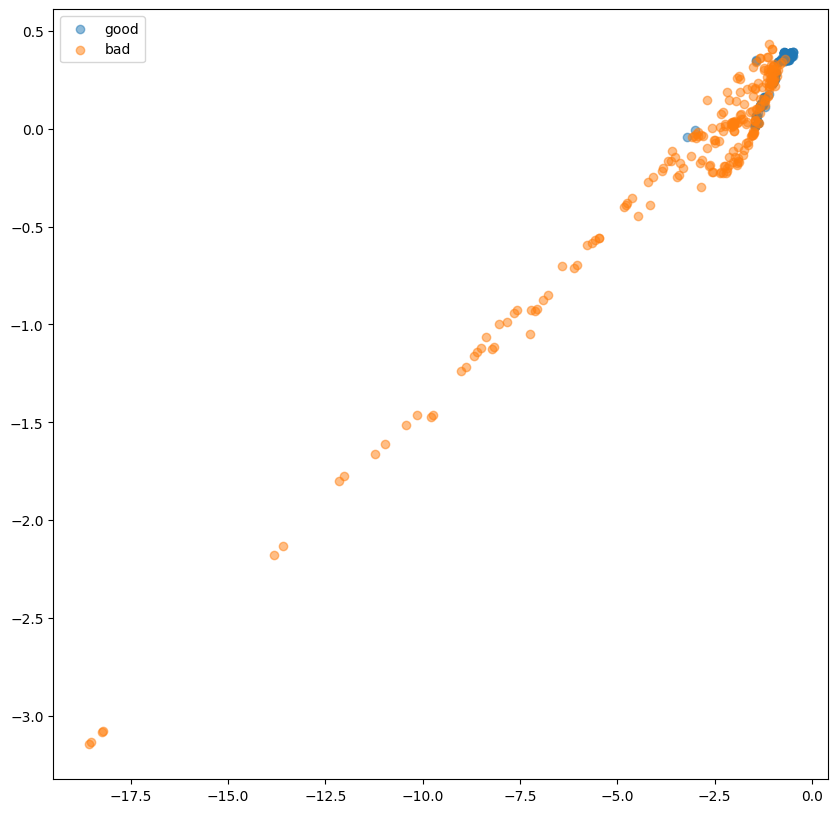

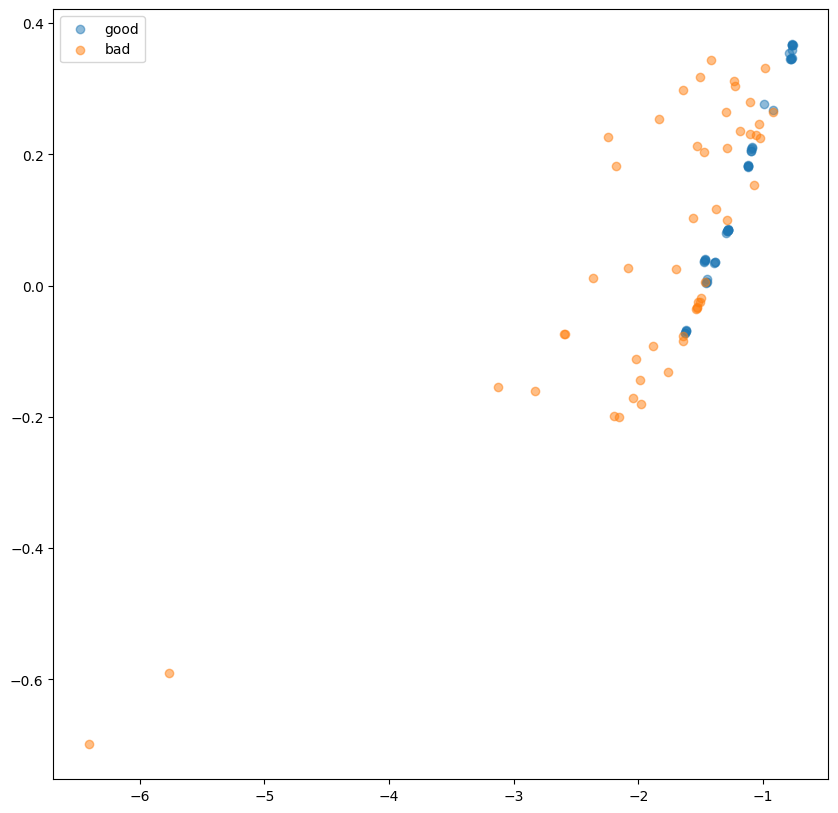

In [59]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

In [26]:
model.load_state_dict(torch.load("./model/mod_19"))

<All keys matched successfully>